<a href="https://colab.research.google.com/github/harigopallak45/stoch_micro_ts/blob/main/micro_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Microsoft Stock**- Time Series Analysis **LSTM**

**Table of Contents**

Forecasting the Stock Market with LSTM


Stock Market:


Understanding the Problem :


What is Long Short Term Memory (LSTM) :


The network has 3 gates:


1| Import libraries


2| EDA


3| some function helper


4| Model


5| Predictions

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Forecasting the Stock Market with LSTM

In [2]:
'''import libraries'''
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/Microsoft_Stock.csv',
                 infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


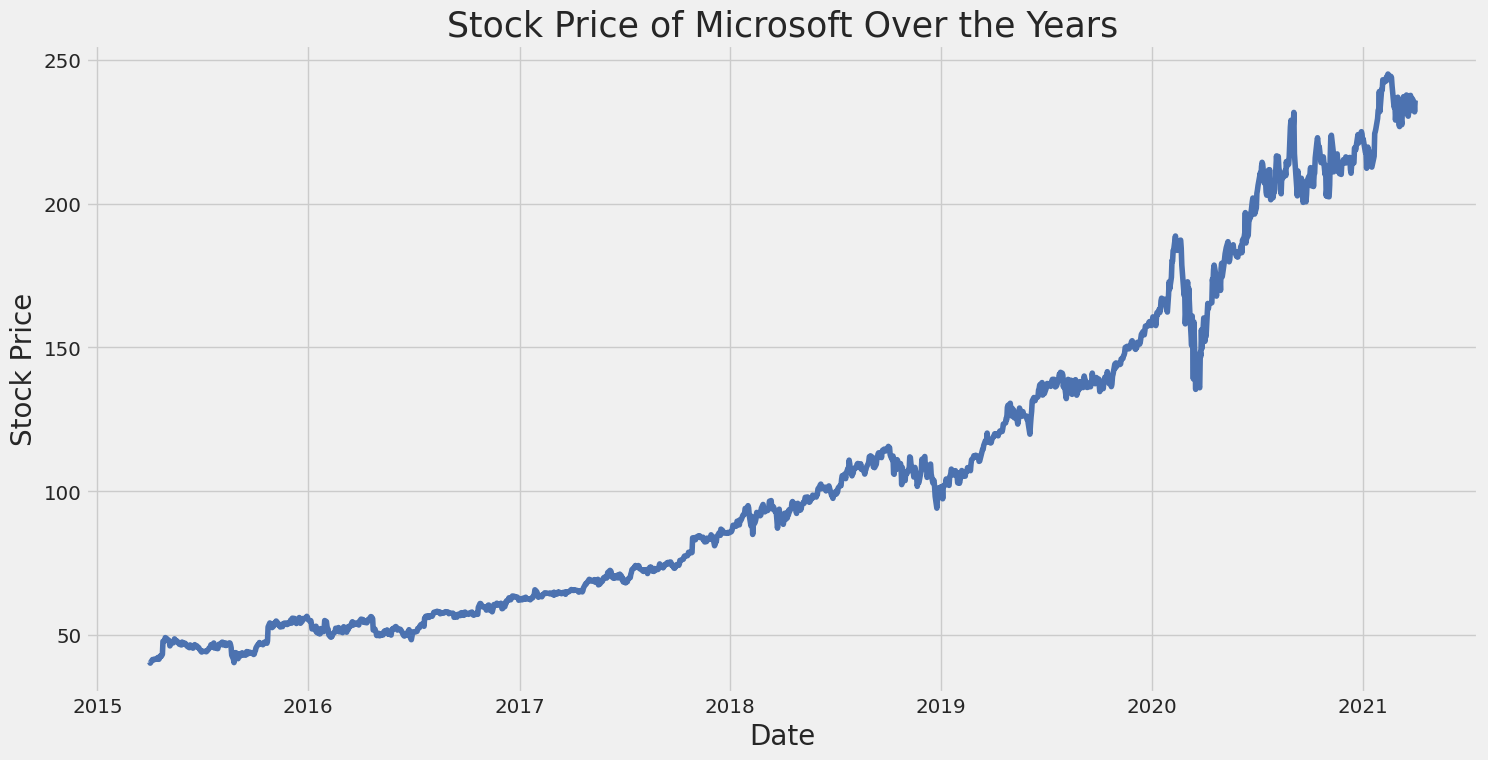

In [6]:
#figure
plt.figure(figsize=(16,8))

plt.plot(df['Close'], label='Close Price history',color='b')
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of Microsoft Over the Years',size=25);

In [8]:
#some function helper
# Normalizes the data
def to_dataset(data):
    data = data.astype('float32')
    #scaler = MinMaxScaler(feature_range=(0,1))
    #return scaler.fit_transform(data)
    return data/255.

# Data train and test
def train_test(data):
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size, :], data[train_size:len(data), :]
    return train, test

# Time windows - use 10 days to forecast the nest 10 days
def windows(sequence, step_in, step_out):
    x, y = [], []
    for i in range(len(sequence)):
        end_i = i + step_in
        out_i = end_i + step_out
        if out_i > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_i, :], sequence[end_i:out_i, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Model
def creat_model(step_in, step_out, features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(step_in, features)))
    model.add(RepeatVector(step_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(features)))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Run all functions
def prepare_training(data, step_in, step_out):
    data = to_dataset(data)
    train, test = train_test(data)
    x_train, x_test = windows(train, step_in, step_out)
    y_train, y_test = windows(test, step_in, step_out)
    features = 1
    return x_train, x_test, y_train, y_test, features

In [9]:
step_in, step_out = 10, 10
epochs = 50
batch_size = 32

early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)
data = df['Close'].values
data = data.reshape(-1, 1)
x_train, y_train, x_test, y_test, feature = prepare_training(data, step_in, step_out)

In [12]:
model = creat_model(step_in, step_out, feature)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=144, verbose=1,
         validation_data=(x_test, y_test), callbacks=[early,reduce])


Epoch 1/50
8/8 [==============================] - 4s 116ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - val_loss: 0.3494 - val_mean_squared_error: 0.3494 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 1s 65ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.1244 - val_mean_squared_error: 0.1244 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 1s 64ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.1573 - val_mean_squared_error: 0.1573 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 1s 67ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.1225 - val_mean_squared_error: 0.1225 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 1s 65ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 1s 67ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0790 - val_mean_sq

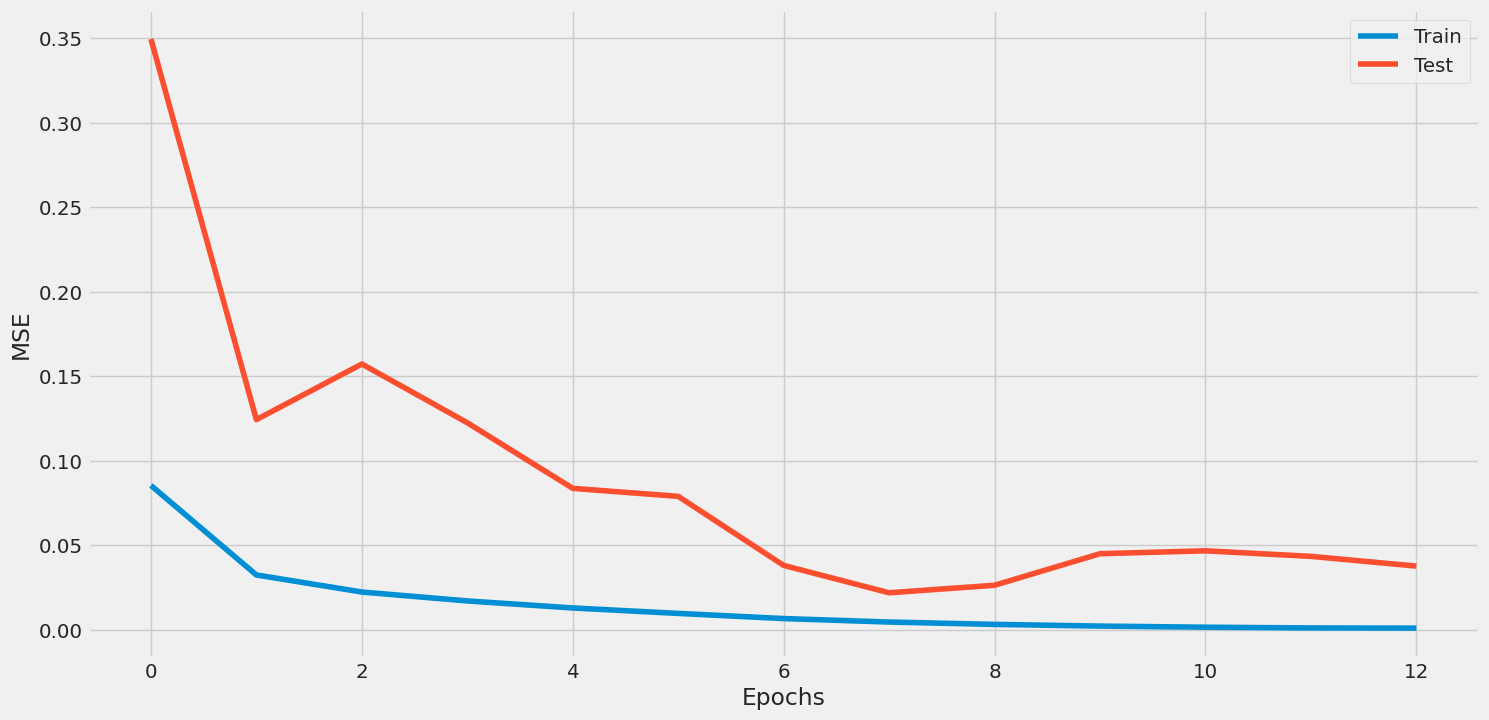

In [13]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Test']);

12/12 [==============================] - 0s 9ms/step


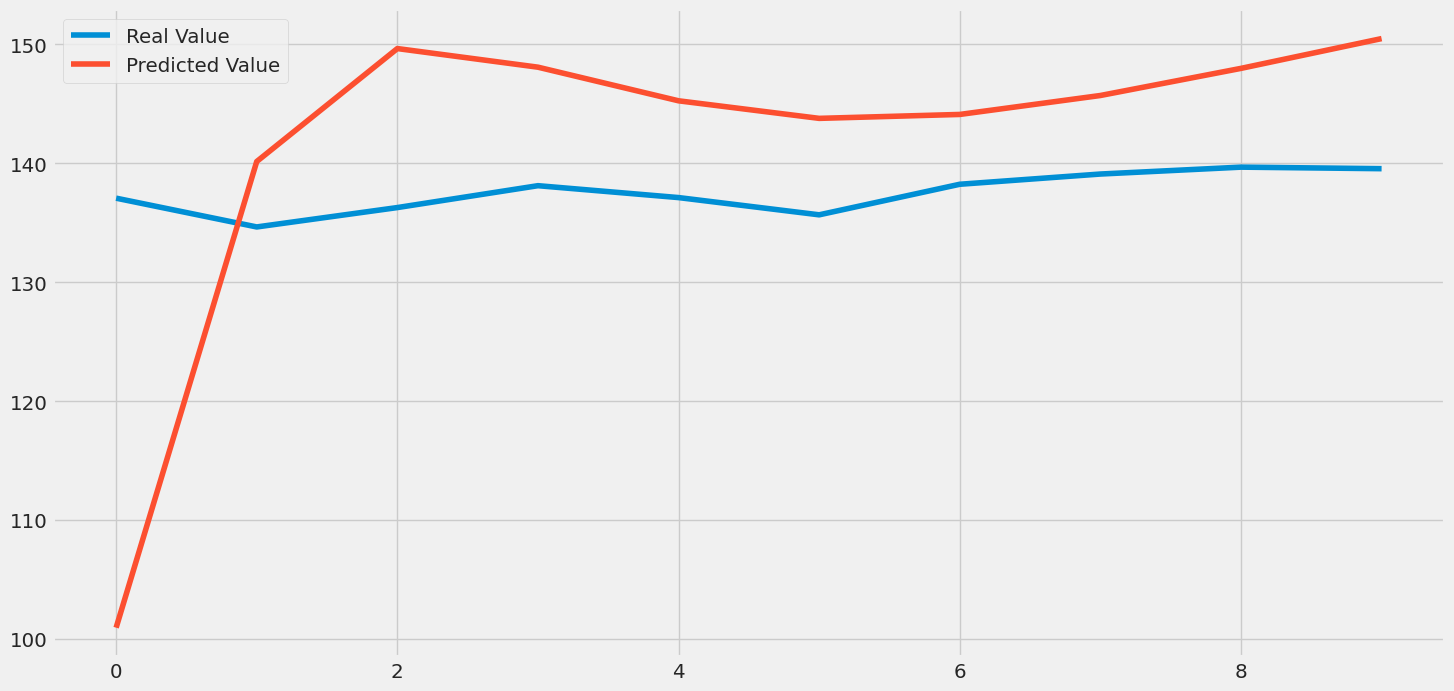

In [14]:
pred = model.predict(x_test)
x = x_test[0]*255.0
y = pred[0]*255.0
plt.plot(x)
plt.plot(y)
plt.legend(['Real Value','Predicted Value']);